# Predictions

## Imports

In [1]:
# load custom scripts
import config

# import the necessary packages
from albumentations.pytorch import ToTensorV2
from skimage import io
from torchvision import transforms
import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torchmetrics

In [2]:
torch.manual_seed(42)

## Plot function

In [3]:
classes = {1: 'hard coral',
           2: 'hard coral bleached',
           3: 'dead coral',
           4: 'other invertebrates',
           5: 'sand/rubble',
           6: 'other',
           7: 'algae',
           8: 'unknown',
           0: 'no label'
          }

In [4]:
# initialize metrics
acc = torchmetrics.Accuracy(ignore_index=0)
f1 = torchmetrics.F1Score(ignore_index=0, mdmc_average='samplewise')
prec = torchmetrics.Precision(ignore_index=0, mdmc_average='samplewise')
rec = torchmetrics.Recall(ignore_index=0, mdmc_average='samplewise')

In [5]:
def prepare_plot(image, gtLabel, gtMask, predLabel):
    
    unnormalize = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                  transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ])])

    boo = torch.clone(gtMask)
    for j in range(1,9):
        boo[boo == j] = 1

    if torch.sum(boo)!=0:
        # extract the true label positions in the prediction
        pixel_pred = torch.mul(boo, predLabel)
        # extract the true label positions in the label
        pixel_truth = torch.mul(boo, gtLabel)
        
        print(acc(pixel_pred, pixel_truth))
        print(f1(pixel_pred, pixel_truth))
        print(prec(pixel_pred, pixel_truth))
        print(rec(pixel_pred, pixel_truth))
        
    # plot the original image, its mask, and the predicted mask
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
    im1 = ax[0].imshow(unnormalize(image[0]).cpu().detach().permute(1, 2, 0))
    ax[0].scatter(np.nonzero(gtMask)[:,1].cpu(), np.nonzero(gtMask)[:,0].cpu(), s=20, marker='.', c='r')

    im2 = ax[1].imshow(gtLabel.numpy(),
                       cmap = plt.cm.get_cmap('tab20', 9),
                       vmin=0, vmax=8)
    ax[1].scatter(np.nonzero(gtMask)[:,1].cpu(), np.nonzero(gtMask)[:,0].cpu(), s=20, marker='.', c='r')

    im3 = ax[2].imshow(predLabel.numpy(),
                       cmap = plt.cm.get_cmap('tab20', 9),
                       vmin=0, vmax=8)
    ax[2].scatter(np.nonzero(gtMask)[:,1].cpu(), np.nonzero(gtMask)[:,0].cpu(), s=20, marker='.', c='r')


    # set the titles of the subplots
    ax[0].set_title("Image")
    ax[1].set_title("Original Labels")
    ax[2].set_title("Predicted Labels")

    # add colour bar
    cbar = fig.colorbar(im3, ticks=list(classes.keys()), fraction=0.035)
    cbar.ax.set_yticklabels(list(classes.values()))

    # set the layout of the figure and display it
    fig.show()

## Testing loop

In [6]:
def make_predictions(model, imagePath):
    # set model to evaluation mode
    model.eval()
    
    # turn off gradient tracking
    with torch.no_grad():
        # load the image from disk
        image = io.imread(imagePath)
        # load the labels from disk
        filename = imagePath.split(os.path.sep)[-1].replace("JPG","png")
        groundTruthPath = os.path.join(config.LABEL_DATASET_PATH, filename)
        gtLabel = io.imread(groundTruthPath)
        # load the mask from disk
        gtMask = io.imread(groundTruthPath.replace('labels', 'masks'))
        
        # apply transformation
        transformed = test_transform(image=image, mask=gtLabel, mask2=gtMask)
        image = transformed["image"]
        gtLabel = transformed["mask"]
        gtMask = transformed["mask2"]

        # create image tensor
        image = np.transpose(image, (2, 0, 1))
        image = np.expand_dims(image, 0)
        image = torch.from_numpy(image)
        image = image.to(config.DEVICE)

        # create mask tensor
        asarray = lambda x: torch.tensor(np.array(x), dtype=torch.long)
        gtLabel = asarray(np.expand_dims(gtLabel, 0))
        gtMask = asarray(np.expand_dims(gtMask, 0))

        # prediction
        predLabel = model(image).squeeze()
        predLabel = torch.argmax(predLabel, dim=0)
        predLabel = predLabel.cpu()
        
        # prepare a plot for visualization
        prepare_plot(image, gtLabel.squeeze(), gtMask.squeeze(), predLabel)


In [7]:
test_transform = A.Compose([
    A.RandomResizedCrop(width=128, height=128, scale=(0.08, 1.0), ratio=(0.75, 1.33)),    
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))],
    additional_targets={'mask2': 'mask'}
)

## Make predictions

[INFO] loading up test image paths...
[INFO] load up model...
tensor(1.)
tensor(0.0078)
tensor(0.0078)
tensor(0.0078)


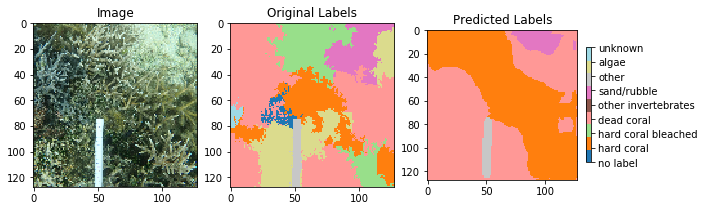

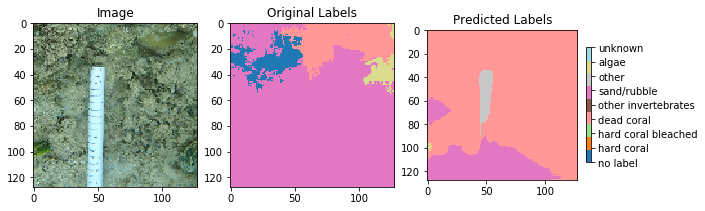

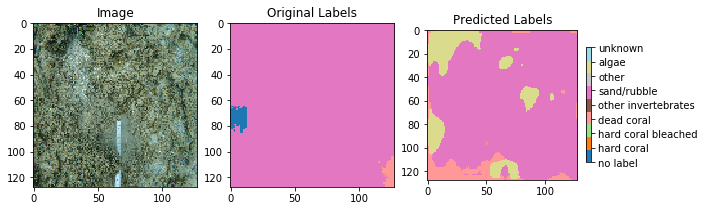

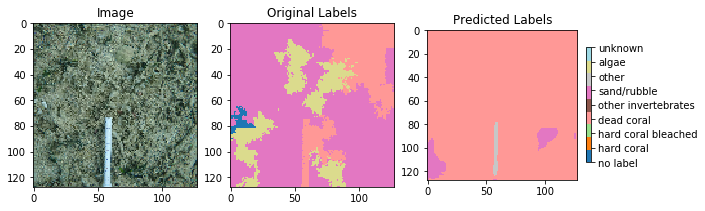

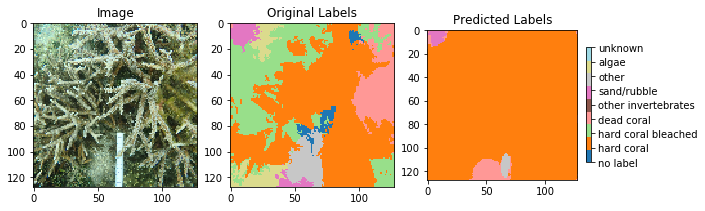

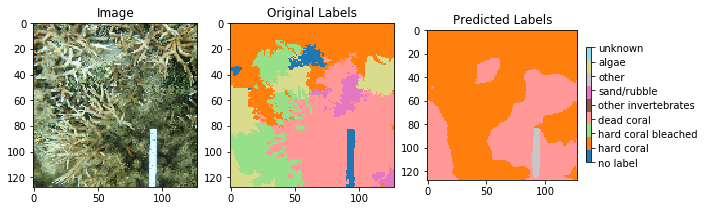

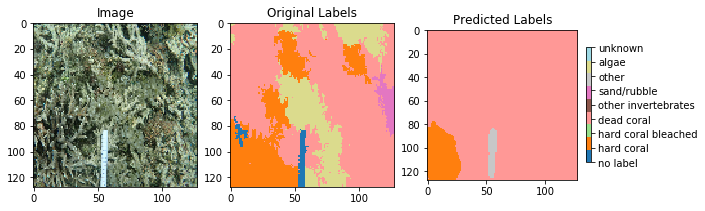

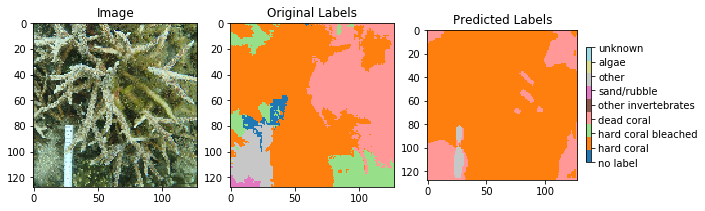

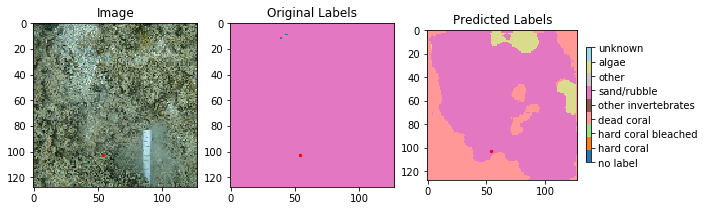

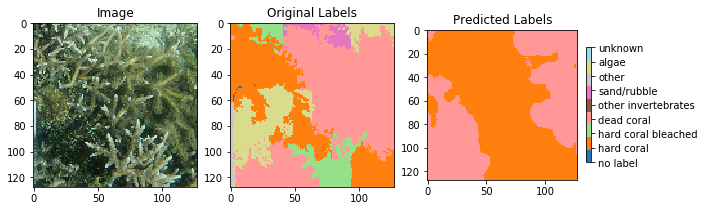

In [9]:
# load the image paths in our testing file and randomly select 10 image paths
print("[INFO] loading up test image paths...")
imagePaths = open(config.TEST_PATHS).read().strip().split("\n")
imagePaths = np.random.choice(imagePaths, size=10)

# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load(config.MODEL_PATH).to(config.DEVICE)

# iterate over the randomly selected test image paths
for path in imagePaths:
    make_predictions(unet, path)